In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import os 
import h5py
import yaml
import tqdm

sys.path.append('../src/')

from f2_cluster_functions import linearizeFP, PVEofPCA, calcSilhScore,calcSilhScoreHierarch, getTopFCatProp, getWF, getFP, getSgram, calcFFT


yamlPath = "/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/yaml/demo.yaml"

In [52]:


####################################################################################
####################################################################################
###
### Load yaml file settings, creat paths, set parameters
###
####################################################################################
####################################################################################



with open(yamlPath) as stream:
    config = yaml.safe_load(stream)
    
path_config = config["paths"]
key = path_config["key"]
print("Project key:", key)



projectPath = path_config["projectPath"]
SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'data/H5files/' + SpecUFEx_H5_name

pathFig = projectPath + 'reports/figures/'
if not os.path.isdir(pathFig):
    os.mkdir(pathFig)
    

#Clustering parameters
cluster_config = config['clusterParams']
clusterOn = cluster_config['clusterOn']               
PVE = cluster_config['PVE']               
method = cluster_config['method']
minK = cluster_config['minK']
maxK = cluster_config['maxK']        
numEx = cluster_config['numEx']       
standardScaler = cluster_config['standardScaler']

Project key: demo


In [38]:
####################################################################################
####################################################################################
###
### Import fingerprints event ids, load and linearize FPs 
###
####################################################################################
####################################################################################

ev_IDs = []

with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    for evID in fileLoad['fingerprints']:
        ev_IDs.append(evID)

        



X = linearizeFP(SpecUFEx_H5_path,ev_IDs) #event IDs needed to get fp from H5



col_names = ['fp' + str(a) for a in range(X.shape[1])]
col_names[-1]

fp_df = pd.DataFrame(X,columns=col_names)
fp_df['ev_ID'] = [str(ev) for ev in ev_IDs]
fp_df['event_ID'] = [str(ev) for ev in ev_IDs]

N = len(fp_df)

print(X.shape)
        

(1815, 225)


In [40]:


####################################################################################
####################################################################################
###
### Perform PCA, create df of PCs up to selected PVE
###
####################################################################################
####################################################################################


PCA_df, numPCA, cum_pve = PVEofPCA(X,cum_pve_thresh=PVE,stand=standardScaler)
XPCA = np.array(PCA_df)


1 0.591898669056
2 0.77214828437
3 0.918651423224
break


In [41]:
####################################################################################
####################################################################################
###
### Clustering: Kmeans or Hierarchical
###
####################################################################################
####################################################################################

range_n_clusters = np.arange(minK,maxK+1)

if method=='kmeans':
    


    Kopt, maxSilScore, avgSils, __, cluster_labels_best, ss_best, __ = calcSilhScore(XPCA,range_n_clusters)

    
    
elif method=='hierarchical':
    

    Kopt, maxSilScore, avgSils, cluster_labels_best, ss_best = calcSilhScoreHierarch(XPCA,range_n_clusters)
    
else:
    
    print('Choose "kmeans" or "hierarchical"')
    
    
# Attach cluster labels to dataframes    
PCA_df['Cluster'] = cluster_labels_best
PCA_df['SS'] = ss_best



kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4


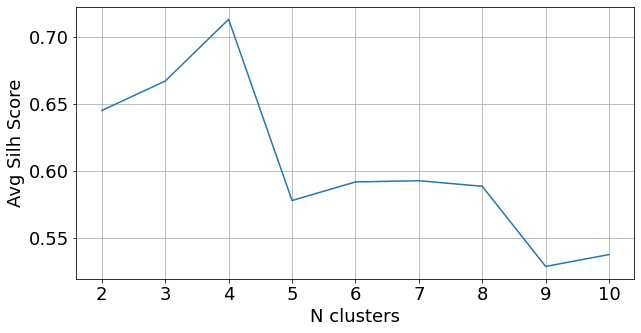

In [53]:
####################################################################################
####################################################################################
###
### Figure 1. Clustering metrics
###
####################################################################################
####################################################################################

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(range_n_clusters,avgSils)
ax.set_xlabel('N clusters')
ax.set_ylabel('Avg Silh Score')
ax.set_xticks(range_n_clusters);
ax.grid()



plt.savefig(pathFig + key + "SilhScore.png")

plt.close()


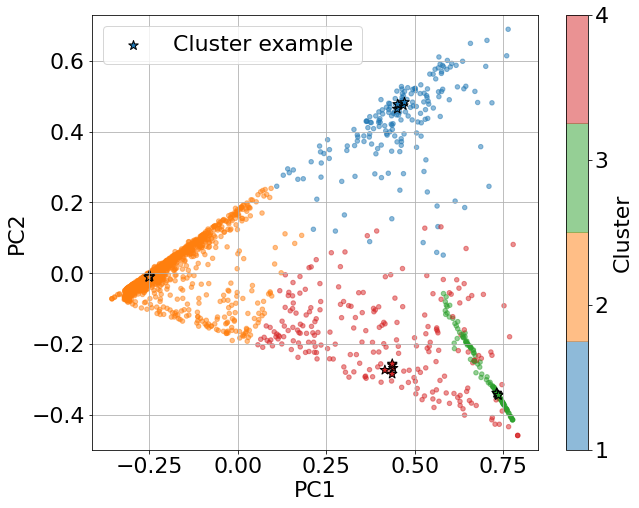

In [55]:


####################################################################################
####################################################################################
###
### Figure 2. PCA colored by cluster assignment
###
####################################################################################
####################################################################################


plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(10,8))
ax = plt.gca()

## Make cluster colormap
cluster_colors = [plt.cm.tab20(i) for i in range(0,Kopt)]
if Kopt <= 10:
    cluster_colors = [plt.cm.tab10(i) for i in range(0,Kopt)]
cmap = ListedColormap(cluster_colors)




topF_df_PCA_list = [] 

for cl in range(1,Kopt+1):
    
    PCA_df_k = PCA_df[PCA_df.Cluster==cl].copy()
    PCA_df_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    topF_df_PCA_list.append(PCA_df_k.iloc[0:numEx])
    
    
topF_df_PCA_list_df = pd.concat(topF_df_PCA_list)    


im = ax.scatter(PCA_df.PC1,PCA_df.PC2,c=PCA_df.Cluster,alpha=.5,cmap=cmap,s=20)
ax.scatter(topF_df_PCA_list_df.PC1,topF_df_PCA_list_df.PC2,marker='*',
           c=topF_df_PCA_list_df.Cluster,s=100,cmap=cmap,edgecolor='k',
           label='Cluster example')

plt.colorbar(im, ticks=range(1,Kopt+1),label='Cluster',ax=ax)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.axis('equal')
ax.grid()
ax.legend();


plt.savefig(pathFig + key + "PCACluster.png")
plt.close()

100%|██████████| 5/5 [00:00<00:00, 51.88it/s]


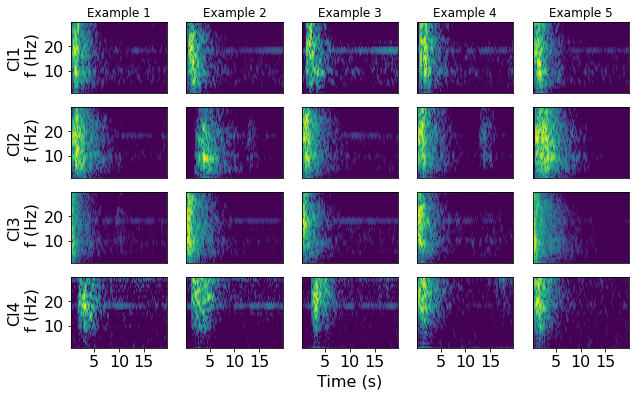

In [83]:
####################################################################################
####################################################################################
###
### Figure 3. Plot spectrogram examples
###
####################################################################################
####################################################################################
plt.rcParams.update({'font.size': 16})



fig, axes = plt.subplots(nrows=Kopt, ncols=numEx, figsize=(numEx*2,Kopt*1.5))

## get sgram freqs and time vectors
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    
    frequencies = fileLoad['fSTFT'].get('fSTFT')[()]
    times =       fileLoad['tSTFT'].get('tSTFT')[()]

    
    
for cl in range(1,Kopt+1):
    
    PCA_df_k = PCA_df[PCA_df.Cluster==cl].copy()
    PCA_df_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    for i in tqdm.tqdm(range(numEx)):
        
        ax = axes[cl-1][i]
        
        indd = PCA_df_k.index[i]
        
        tSTFT, fSTFT, sgram = getSgram(ev_IDs[indd], SpecUFEx_H5_path)
        im = ax.pcolormesh(tSTFT,
                            fSTFT,
                            sgram,
                            cmap=plt.cm.viridis,
                            shading='auto')

           
            
        if i==numEx//2:
            ax.set_xlabel('Time (s)')
            
        if i ==0:
            ax.set_ylabel('Cl' + str(cl) + '\n f (Hz)') 
            
        if cl!=Kopt:
            ax.set_xlabel('')
            ax.set_xticklabels([])           
            ax.set_xticks([])        
        
        if i!=0:
            ax.set_yticks([])
            ax.set_yticklabels([])


            
        if cl==1:    
            ax.set_title('Example ' + str(i+1),pad=5,fontsize=12)     

    




plt.savefig(pathFig + key + "ClusterExamples.png")
plt.close()
